In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms, datasets
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [3]:
class PGD():
  def __init__(self,model,eps=0.3,alpha=2/255,steps=40,random_start=True):
    self.eps = eps
    self.model = model
    self.attack = "Projected Gradient Descent"
    self.alpha = alpha
    self.steps = steps
    self.random_start = random_start
    self.supported_mode = ["default"]
  
  def forward(self,images,labels):
    images = images.clone().detach()
    labels = labels.clone().detach()


    loss = nn.CrossEntropyLoss()

    adv_images = images.clone().detach()

    if self.random_start:
        adv_images = adv_images + torch.empty_like(adv_images).uniform_(-self.eps, self.eps)
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

    for step in range(self.steps):
        adv_images.requires_grad = True
        outputs = self.model(adv_images)
        cost = loss(outputs, labels)
        grad = torch.autograd.grad(cost, adv_images,retain_graph=False, create_graph=False)[0]

        adv_images = adv_images.detach() + self.alpha*grad.sign()
        delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
        adv_images = torch.clamp(images + delta, min=0, max=1).detach()

    return adv_images

In [4]:
class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet,self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    self.maxpool = nn.MaxPool2d(2)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(1024, 10)

  def forward(self,x):
    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.maxpool(x)
    x = self.relu(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    # x = F.softmax(x)
    return x

In [5]:
train = datasets.MNIST('./dataset/', train=True,
                       transform=transforms.Compose([transforms.ToTensor(),]),
                       download=True)
train_loader = DataLoader(train, batch_size=128)

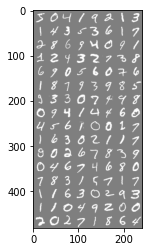

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7,
        1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0,
        7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0,
        2, 0, 2, 7, 1, 8, 6, 4])


In [6]:
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(labels)

In [7]:
model = NeuralNet()

In [8]:
model.train()
optimiser = optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

In [9]:
for epoch in range(10):
  epoch_loss = 0
  correct, total = 0,0
  for i,data in enumerate(train_loader,0):
    inputs,labels = data
    optimiser.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs,labels)
    loss.backward()
    optimiser.step()
    epoch_loss += loss.item()
    pred = torch.max(outputs,1)
    total += labels.size(0)
    correct += (pred.indices == labels).sum().item()
  print("Epoch:",epoch+1, " Loss: ",epoch_loss," Accuracy:",correct/total)

Epoch: 1  Loss:  146.77179141622037  Accuracy: 0.9092833333333333
Epoch: 2  Loss:  40.73488439572975  Accuracy: 0.97445
Epoch: 3  Loss:  29.953438107506372  Accuracy: 0.9809833333333333
Epoch: 4  Loss:  24.529049017000943  Accuracy: 0.9843666666666666
Epoch: 5  Loss:  21.05477899959078  Accuracy: 0.98665
Epoch: 6  Loss:  18.548920421977527  Accuracy: 0.9883666666666666
Epoch: 7  Loss:  16.597386216075392  Accuracy: 0.9895333333333334
Epoch: 8  Loss:  14.969123948947527  Accuracy: 0.9909166666666667
Epoch: 9  Loss:  13.62784149957588  Accuracy: 0.99175
Epoch: 10  Loss:  12.44476680457592  Accuracy: 0.9925833333333334


In [10]:
os.makedirs('./model',exist_ok=True)

In [11]:
torch.save(model.state_dict(), './model/pdg_net.pth')

In [12]:
model.load_state_dict(torch.load('./model/pdg_net.pth'))

<All keys matched successfully>

In [13]:
di = iter(train_loader)
sample_images, sample_labels = di.next()

with torch.no_grad():
  op = model(sample_images)
  _,p = torch.max(op.data, dim = 1)
  print(p.shape,sample_labels.shape,sample_images.shape)

torch.Size([128]) torch.Size([128]) torch.Size([128, 1, 28, 28])


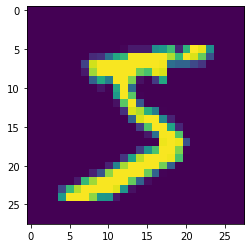

Actual Label: 5 Predicted Label: 5



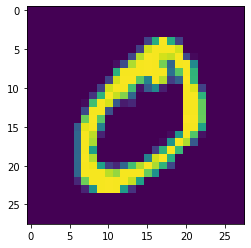

Actual Label: 0 Predicted Label: 0



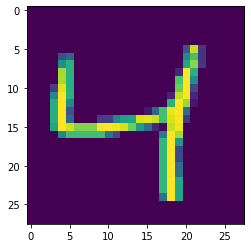

Actual Label: 4 Predicted Label: 4



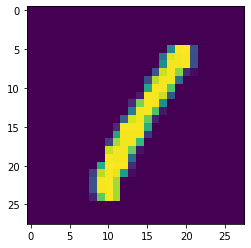

Actual Label: 1 Predicted Label: 1



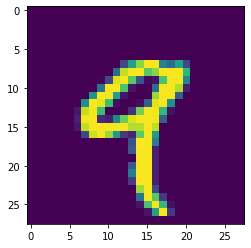

Actual Label: 9 Predicted Label: 9



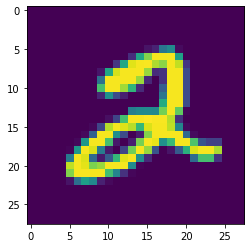

Actual Label: 2 Predicted Label: 2



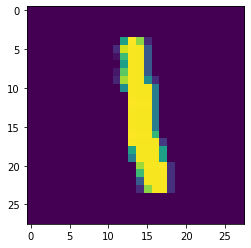

Actual Label: 1 Predicted Label: 1



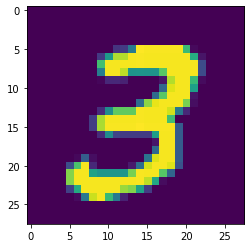

Actual Label: 3 Predicted Label: 3



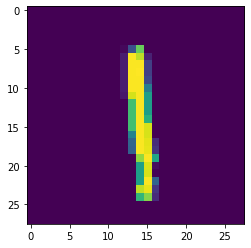

Actual Label: 1 Predicted Label: 1



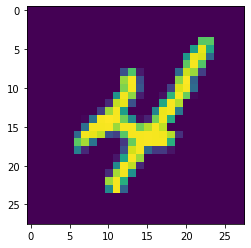

Actual Label: 4 Predicted Label: 4



In [14]:
count = 0
for img,y,y_pred in zip(sample_images,sample_labels,p):
  mg = img / 2 + 0.5  
  npimg = img.numpy()
  plt.imshow(np.squeeze(np.transpose(npimg, (1, 2, 0))))
  plt.show()
  count += 1
  print("Actual Label:", int(y), "Predicted Label:", int(y_pred))
  print()
  if(count>=10):
    break

In [15]:
iter_attack = iter(train_loader)
atk_images, atk_labels = iter_attack.next()
pgd = PGD(model = model)
x_adv = pgd.forward(atk_images,atk_labels)
adv_op = model(x_adv)
_,p_adv = torch.max(adv_op, dim = 1)

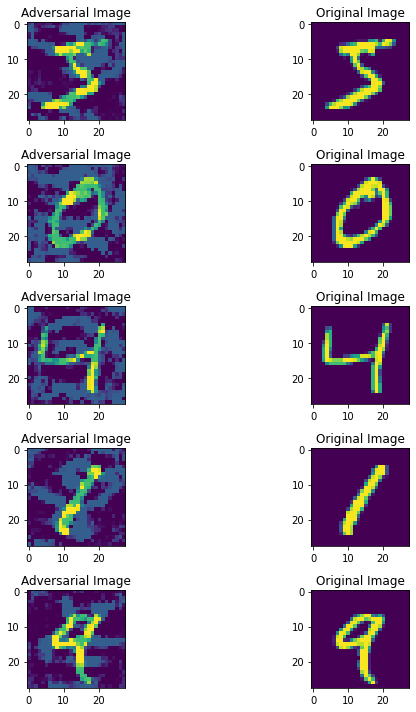

In [16]:
f, axarr = plt.subplots(5,2,figsize=(10,10))
for i,img in enumerate(zip(x_adv,atk_images)):
  img1,img2 = img
  img1,img2 = img1 / 2 + 0.5, img2/2 + 0.5  
  npimg1,npimg2 = img1.numpy(),img2.numpy()
  axarr[i,0].imshow(np.squeeze(np.transpose(npimg1, (1, 2, 0))))
  axarr[i, 0].set_title("Adversarial Image")
  axarr[i,1].imshow(np.squeeze(np.transpose(npimg2, (1, 2, 0))))
  axarr[i,1].set_title("Original Image")
  if(i>=4):
    break
f.tight_layout()
plt.show()

In [17]:
adv_pred = torch.max(adv_op,1)
correct = (adv_pred.indices == atk_labels).sum()
total = len(adv_op)
print(int(correct),total)
print("Accuracy after PGD attack:",(int(correct)/total))

0 128
Accuracy after PGD attack: 0.0


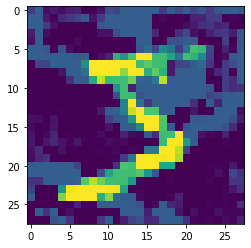

Actual Label: 5 Predicted Label: 3



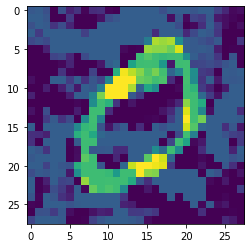

Actual Label: 0 Predicted Label: 2



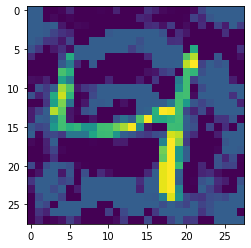

Actual Label: 4 Predicted Label: 9



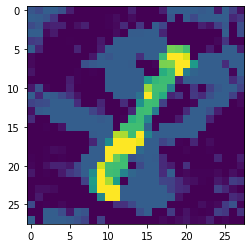

Actual Label: 1 Predicted Label: 8



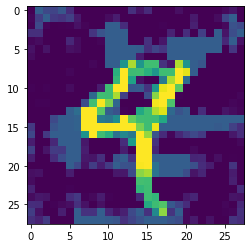

Actual Label: 9 Predicted Label: 4



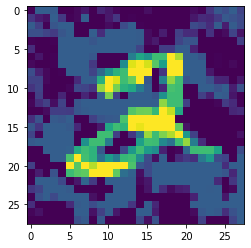

Actual Label: 2 Predicted Label: 3



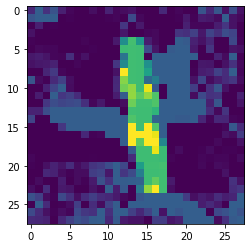

Actual Label: 1 Predicted Label: 4



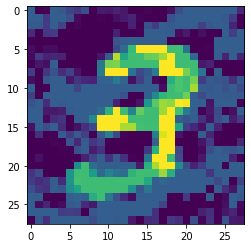

Actual Label: 3 Predicted Label: 9



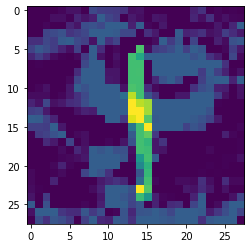

Actual Label: 1 Predicted Label: 8



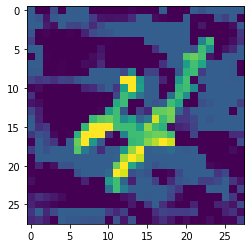

Actual Label: 4 Predicted Label: 2



In [18]:
count = 0
plt.rcParams["figure.figsize"] = (4,4)
for img,y,y_pred in zip(x_adv,atk_labels,adv_pred.indices):
  img = img / 2 + 0.5  
  npimg = img.numpy()
  plt.imshow(np.squeeze(np.transpose(npimg, (1, 2, 0))))
  plt.show()
  count += 1
  print("Actual Label:", int(y), "Predicted Label:", int(y_pred))
  print()
  if(count>=10):
    break

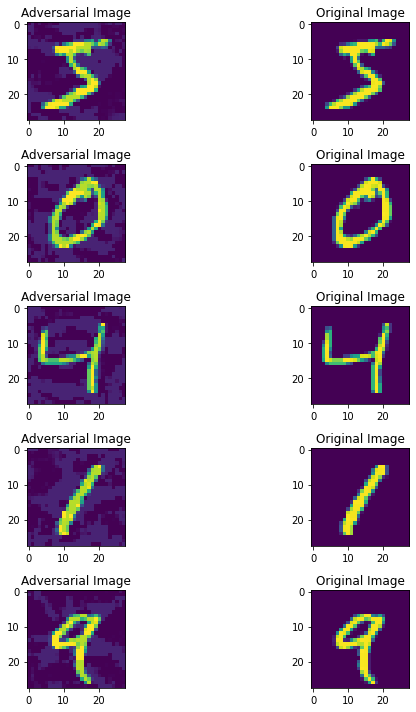

102 128
Accuracy after PGD attack: 0.796875


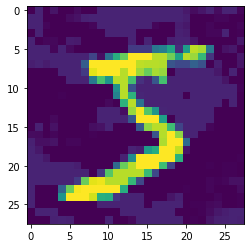

Actual Label: 5 Predicted Label: 3



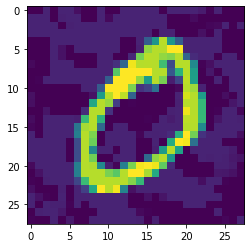

Actual Label: 0 Predicted Label: 0



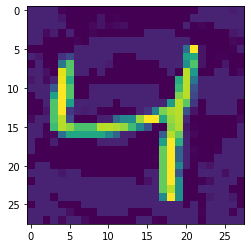

Actual Label: 4 Predicted Label: 4



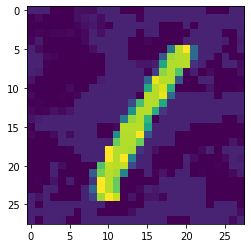

Actual Label: 1 Predicted Label: 1



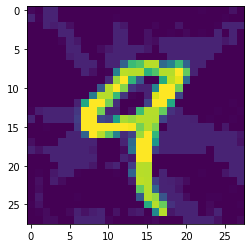

Actual Label: 9 Predicted Label: 4



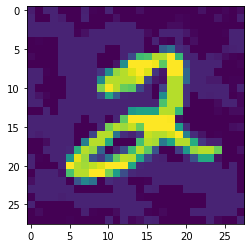

Actual Label: 2 Predicted Label: 2



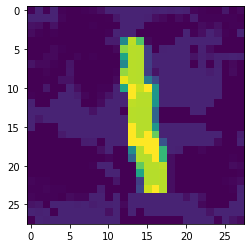

Actual Label: 1 Predicted Label: 1



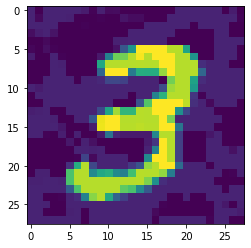

Actual Label: 3 Predicted Label: 3



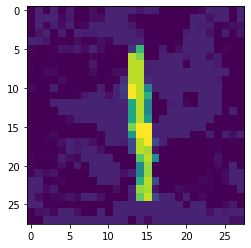

Actual Label: 1 Predicted Label: 1



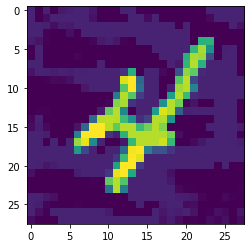

Actual Label: 4 Predicted Label: 4



In [19]:
iter_attack = iter(train_loader)
atk_images, atk_labels = iter_attack.next()
pgd = PGD(model = model,eps = 0.1)
x_adv = pgd.forward(atk_images,atk_labels)
adv_op = model(x_adv)
_,p_adv = torch.max(adv_op, dim = 1)
f, axarr = plt.subplots(5,2,figsize=(10,10))
for i,img in enumerate(zip(x_adv,atk_images)):
  img1,img2 = img
  img1,img2 = img1 / 2 + 0.5, img2/2 + 0.5  
  npimg1,npimg2 = img1.numpy(),img2.numpy()
  axarr[i,0].imshow(np.squeeze(np.transpose(npimg1, (1, 2, 0))))
  axarr[i, 0].set_title("Adversarial Image")
  axarr[i,1].imshow(np.squeeze(np.transpose(npimg2, (1, 2, 0))))
  axarr[i,1].set_title("Original Image")
  if(i>=4):
    break
f.tight_layout()
plt.show()
adv_pred = torch.max(adv_op,1)
correct = (adv_pred.indices == atk_labels).sum()
total = len(adv_op)
print(int(correct),total)
print("Accuracy after PGD attack:",(int(correct)/total))
count = 0
plt.rcParams["figure.figsize"] = (4,4)
for img,y,y_pred in zip(x_adv,atk_labels,adv_pred.indices):
  img = img / 2 + 0.5  
  npimg = img.numpy()
  plt.imshow(np.squeeze(np.transpose(npimg, (1, 2, 0))))
  plt.show()
  count += 1
  print("Actual Label:", int(y), "Predicted Label:", int(y_pred))
  print()
  if(count>=10):
    break